In [142]:
#Loading the libraries.
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn import datasets
from nltk import ngrams
import time
import random
import warnings
warnings.filterwarnings("ignore")

In [143]:
#Loading in scenario 10.
data = pd.read_csv("capture20110818.binetflow")

In [144]:
#Fixing the labels to appropriate values. Background->-1, Normal->0, Malicious->,1.
Labels = [] 
for i in data.Label.values:
    if re.search("Background",i)!=None:
        Labels.append(-1)
    elif re.search("Normal",i)!=None:
        Labels.append(0)
    elif re.search("Botnet",i)!=None:
        Labels.append(1)
data["Label"]=Labels
data.Label.unique()        

array([-1,  0,  1], dtype=int64)

In [145]:
#Creating new dataframe by removing background netflow data.
data_WB = data.loc[data["Label"]!=-1]

In [146]:
#Just run this twice to kill the annoying warning. Converting StartTime to a datetime variable. 
data_WB.loc[:,"StartTime"] = pd.to_datetime(data_WB["StartTime"])

In [147]:
#Count of missing values in the columns of the dataset.
countofnas=[]
for i in data_WB.columns:
    tf= data_WB[i].isna()
    countofna=0
    for j in tf.values:
        if j==True:
            countofna+=1
    countofnas.append(countofna)        
for i,j in zip(countofnas,data_WB.columns):
    if i!=0:
        print('Column name-'+str(j))
        print("Count of nas="+str(i)+"\n")            

Column name-Sport
Count of nas=27

Column name-Dport
Count of nas=101196

Column name-State
Count of nas=1227

Column name-sTos
Count of nas=29

Column name-dTos
Count of nas=107104



In [148]:
#We see that sTos and dTos are also useless. Better to get rid of it. 
data_WB.sTos.unique(),data_WB.dTos.unique()

(array([ 0., nan]), array([ 0., nan]))

In [149]:
#Due to large number of missing values, removing dTos and Dport as it will only cloud results. Removing sTos as it's useless.
data_WB_cleaned = data_WB.drop(columns=["dTos","Dport","sTos"])

In [150]:
# For the label encoding, replacing nans with default values for State and Sport and converting them to categorical. 
data_WB_cleaned.loc[data_WB['State'].isna(),'State'] = "UNK"
data_WB_cleaned.loc[data_WB['Sport'].isna(),'Sport'] = '0000'
data_WB_cleaned.loc[:,"Sport"]=data_WB_cleaned["Sport"].astype('category')
data_WB_cleaned.loc[:,"State"]=data_WB_cleaned["State"].astype('category')
data_vis=data_WB_cleaned.copy()

In [151]:
#Converting categorical variables in numerical ones using label encoder to be used for correlation. 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
categorical_columns=['Proto','Dir','SrcAddr','DstAddr',"State","Sport"]
for i in categorical_columns:
    data_WB_cleaned.loc[:,i] = le.fit_transform(data_WB_cleaned[i])

In [152]:
data_M = data_WB_cleaned.loc[data_WB_cleaned["Label"]==1] # This stores data on malicious netflows.
data_NM = data_WB_cleaned.loc[data_WB_cleaned["Label"]==0]# This stores data on normal netflows. 

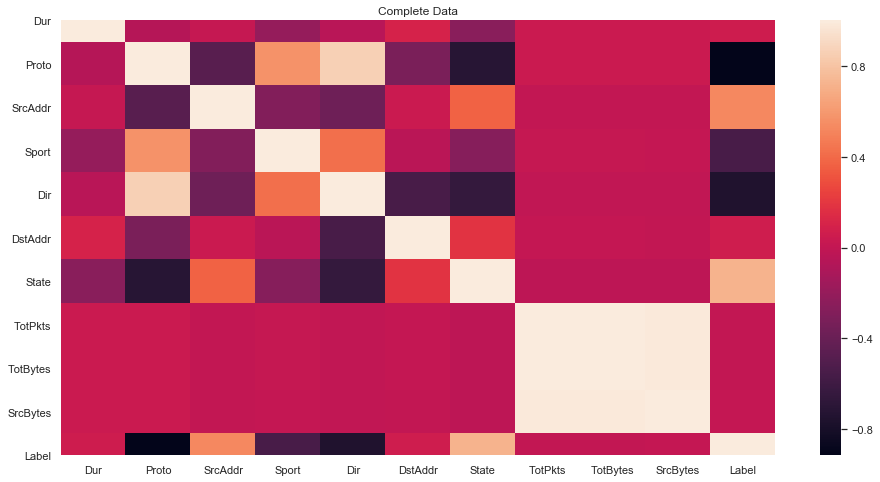

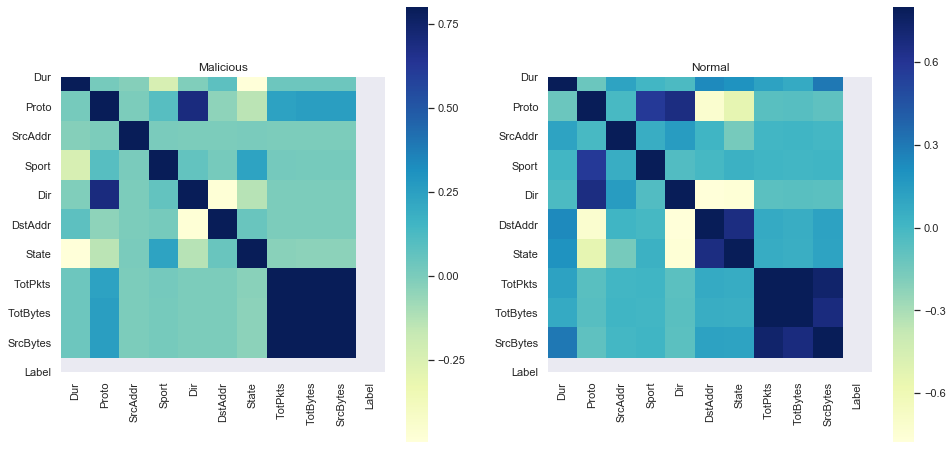

In [153]:
#correlation matrices
f, (ax1) = plt.subplots(1,figsize =(16, 8))
sns.heatmap(data_WB_cleaned.corr())
ax1.set_title('Complete Data')
plt.show()


f, (ax1, ax2) = plt.subplots(1,2,figsize =(16, 8))

sns.heatmap(data_M.corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Malicious')

sns.heatmap(data_NM.corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu');
ax2.set_title('Normal')

plt.show()

In [154]:
# I like the numbers yo!
data_WB_cleaned.corr()

,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,State,TotPkts,TotBytes,SrcBytes,Label
Dur,1.000000,-0.059651,0.019821,-0.202402,-0.045376,0.101189,-0.253972,0.040007,0.041698,0.039328,0.050622
Proto,-0.059651,1.000000,-0.480068,0.570802,0.860547,-0.318632,-0.712716,0.041047,0.042357,0.039165,-0.914309
SrcAddr,0.019821,-0.480068,1.000000,-0.284142,-0.369949,0.036393,0.369286,-0.000524,0.000155,0.003175,0.523478
Sport,-0.202402,0.570802,-0.284142,1.000000,0.417685,-0.033035,-0.269878,0.014761,0.013651,0.009765,-0.553765
Dir,-0.045376,0.860547,-0.369949,0.417685,1.000000,-0.549063,-0.650457,-0.004379,-0.005671,-0.005320,-0.754101
DstAddr,0.101189,-0.318632,0.036393,-0.033035,-0.549063,1.000000,0.179736,0.008281,0.007701,0.000994,0.062006
State,-0.253972,-0.712716,0.369286,-0.269878,-0.650457,0.179736,1.000000,-0.020216,-0.021621,-0.018281,0.718407
TotPkts,0.040007,0.041047,-0.000524,0.014761,-0.004379,0.008281,-0.020216,1.000000,0.998092,0.992488,-0.001117
TotBytes,0.041698,0.042357,0.000155,0.013651,-0.005671,0.007701,-0.021621,0.998092,1.000000,0.991953,-0.000018
SrcBytes,0.039328,0.039165,0.003175,0.009765,-0.005320,0.000994,-0.018281,0.992488,0.991953,1.000000,0.006605


In [155]:
# These are the top 3 most important features in determining whether a data point is malicious because they have the highest correlation with the label. Oh yeah!
data_WB_cleaned.Proto.unique(),data_WB_cleaned.Dir.unique(),data_WB_cleaned.State.unique()

(array([2, 3, 0, 1], dtype=int64),
 array([4, 3, 0, 5, 1, 2], dtype=int64),
 array([ 57,  12,   4,  27,  54,  14,  59,  32,  91,  20,  13,  72,  34,
         96,  42,  75,  39,  40,  31,  90,  81,  93,  19,  25,  22,  95,
         33, 115,  71,  89,  36,  86,  51, 103,  44, 101,  67,  50,  74,
          8,   7,  73,  43,  68,  83,  82,  52,   0,  46,   6,  47, 118,
          5,  41,  94,  63,  45, 100, 102,  62, 104,  49,  48, 114, 111,
        116, 113, 110, 105, 112, 117,  80,  99,  60, 109, 108,  61,  35,
         55,   3,  56,  64,  70,  65,  29,  10,  97,  53,  85,  11,  21,
         76,  84,   1,  77,  66,  15,  78,   9,  24,  18,  92,  17,  79,
         98,  37,  26,  28,  69, 107,  23,  87,  58,  30,  88, 119,  38,
        106,   2,  16], dtype=int64))

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


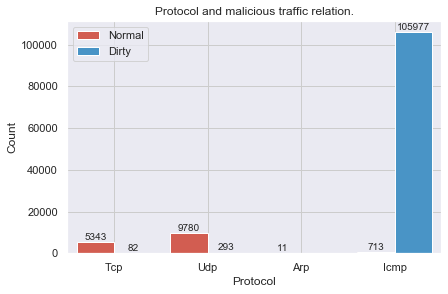

In [156]:
sns.set(rc={'figure.figsize':(6.7,4.27)})
    
flatui = ["#e74c3c","#3498db", "#2ecc71"]
ax = sns.countplot(x="Proto", hue="Label", data=data_vis, palette=flatui)
ax.set_title('Protocol and malicious traffic relation.')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel('Protocol')
ax.set(xticklabels=["Tcp","Udp","Arp","Icmp"])
ax.legend(["Normal","Dirty"])
max_height = 0

for p in ax.patches:
    if p.get_height() > max_height:
        max_height = p.get_height()
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 0.01*max_height,'{:1d}'.format(height.astype(int)),
            ha="center",size=10)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


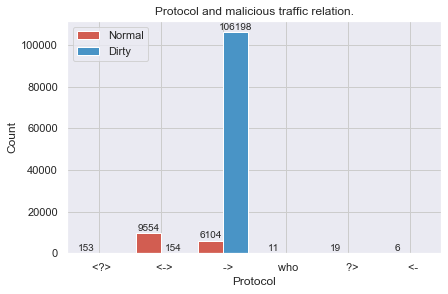

In [157]:
sns.set(rc={'figure.figsize':(6.7,4.27)})
    
flatui = ["#e74c3c","#3498db", "#2ecc71"]
ax = sns.countplot(x="Dir", hue="Label", data=data_vis, palette=flatui)
ax.set_title('Protocol and malicious traffic relation.')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel('Protocol')
ax.legend(["Normal", "Dirty"])
max_height = 0

for p in ax.patches:
    if p.get_height() > max_height:
        max_height = p.get_height()
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 0.01*max_height,'{:1d}'.format(height.astype(int)),
            ha="center",size=10)

From the below visualisation we can see "Proto" and "Dir" which is already discrete due it being categorical has a major influence on the chance of making a certain record in the netflow data malicious. "State" feature is also very important but the visualisation is not useful due to too many categories. Now returning to the heatmaps of the malicious and normal datasets and observing the correlations for "Proto" and "State" with the other variables, we see that "Proto" has a higher correlation with the "TotBytes" in the malicious dataset than the normal dataset which means, "TotBytes" has a different behaviour for malicious netflows. Similarly, we see the "State" feature has very different correlations with the "Dur" feature between the malicious and normal datasets. With this premise, I believe discretizing the "TotBytes" and "Dur" are going to useful for studying an infected host. 

For this task, first I select a certain infected host. Then I perform K-means clustering on my two chosen features and using the elbow method on the within sum of squares for the clusters, I choose the appropriate number of bins for both features. I then discretize and visualise and end with my explanations. 

In [184]:
#Selecting a certain infected host.
data_infected_host = data_M.loc[data_M["SrcAddr"]==12]

In [185]:
#Distortions for DUR.
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data_infected_host["Dur"].values.reshape(-1,1))
    distortions.append(kmeanModel.inertia_)

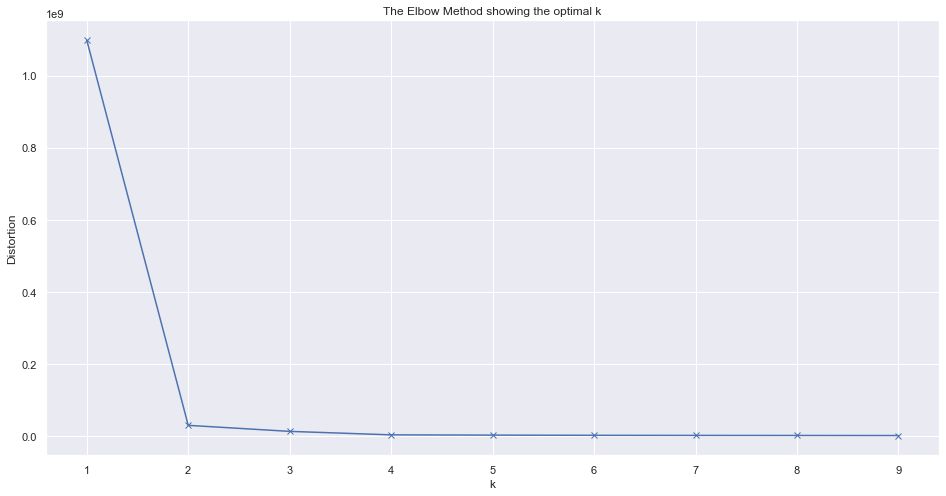

In [186]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Based on the elbow method, the right number of bins for "Dur" feature is 2 but I'm going to try to use 3 just in case.

In [187]:
#Distortions for TotBytes
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data_infected_host["TotBytes"].values.reshape(-1,1))
    distortions.append(kmeanModel.inertia_)

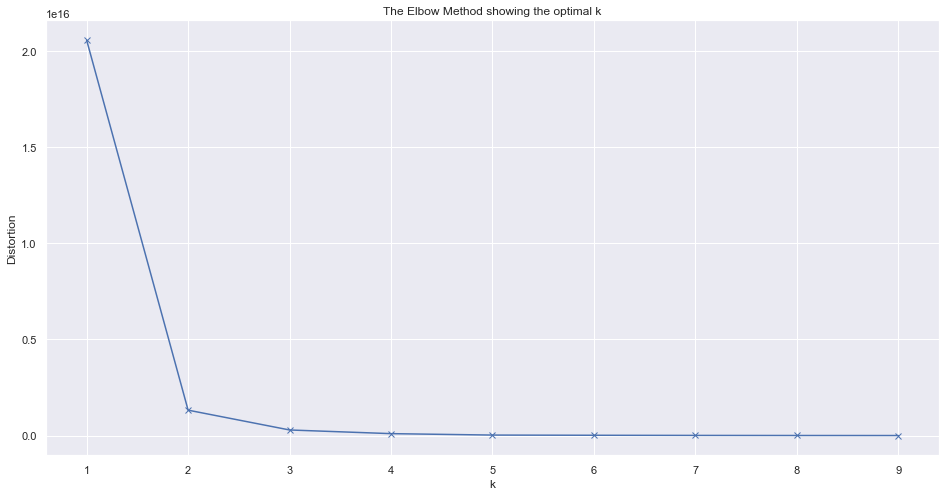

In [188]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Based on the elbow method again, the right number of bins for "TotBytes" feature is 3.

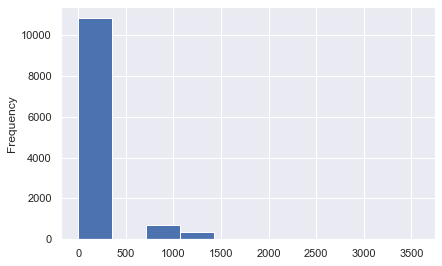

In [189]:
ax=data_infected_host["Dur"].plot(kind="hist")

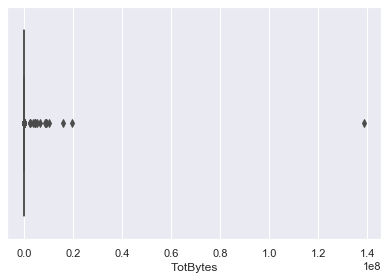

In [190]:
ax=sns.boxplot(data_infected_host["TotBytes"])

There seems to be a great deal of outliers in both features, therefore I must make then a bit more continous by removing outliers to discretize them better. 

In [191]:
#This range isn't right. 
data_infected_host["TotBytes"].min(),data_infected_host["TotBytes"].max()

(60, 138720832)

In [192]:
TotBytes = data_infected_host["TotBytes"].values

In [193]:
#Must see what's wrong.
TotBytes.sort()
for i in TotBytes:
    print(i)

60
60
60
180
180
180
203
203
203
203
460
479
479
479
555
555
555
590
590
590
882
882
882
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1

1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066


1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066


1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066


1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066


2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
2132
3198
3198
3198
3198
3198
3198
3198
3198
3198
3198
3198
3198
3198
3198
3198
3198
3198
3198
3198
5330
7462
8528
8528
9594
10660
10660
10660
10660
10660
10660
10660
10660
10660
11726
11726
11726
11726
11726
1

In [194]:
#last 20 values are very large as compared to the rest. 
TotBytes_Pure = TotBytes[:-20]

In [195]:
# Getting the outliers to see what they look like for the reviewer.
TotBytes_Outliers=TotBytes[-20:]

In [196]:
#Look at these shameful criminals. 
TotBytes_Outliers

array([  2305298,   2333429,   2531304,   3646000,   4208568,   4254406,
         4285320,   4300244,   4340752,   5398829,   6485635,   8626072,
         8750794,   8797698,   8838206,   8908562,  10312236,  15810245,
        19679618, 138720832], dtype=int64)

In [197]:
#Therefore we have 2 valid intervals based on quantile based discretization and the 3rd will be for the outliers. 
pd.qcut(TotBytes_Pure, q=2)

[(59.999, 1066.0], (59.999, 1066.0], (59.999, 1066.0], (59.999, 1066.0], (59.999, 1066.0], ..., (1066.0, 55432.0], (1066.0, 55432.0], (1066.0, 55432.0], (1066.0, 55432.0], (1066.0, 55432.0]]
Length: 11854
Categories (2, interval[float64]): [(59.999, 1066.0] < (1066.0, 55432.0]]

In [198]:
#Lets discretize the feature TotBytes now.
data_infected_host.loc[(data_infected_host['TotBytes']>59.99) &(data_infected_host['TotBytes']<=1066.0) ,'New_TotBytes'] = 'Level_1'
data_infected_host.loc[(data_infected_host['TotBytes']>1066) &(data_infected_host['TotBytes']<=55432) ,'New_TotBytes'] = 'Level_2'
data_infected_host.loc[(data_infected_host['TotBytes']>55432),'New_TotBytes'] = 'Level_3'

In [173]:
data_infected_host["New_TotBytes"].unique()

array(['Level_1', 'Level_2', 'Level_3'], dtype=object)

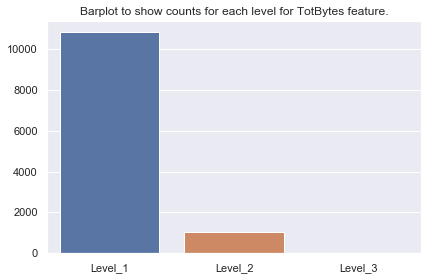

In [174]:
ax=sns.barplot(data_infected_host["New_TotBytes"].value_counts().index,data_infected_host["New_TotBytes"].value_counts().values)
ax.set_title("Barplot to show counts for each level for TotBytes feature.")
plt.show()

In [203]:
# Now doing the same for "Dur" feature. This range doesn't look right. 
data_infected_host["Dur"].min(),data_infected_host["Dur"].max()

(0.0, 3570.946045)

In [204]:
Dur = data_infected_host["Dur"].values

In [205]:
#Very important to sort and look at the kind of values. 
Dur.sort()
for i in Dur:
    print(i)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


Problem is we cannot get well defined quantiles for such a discontinous array of values. As pd.qcut(Dur,2) This doesn't work. But based on my sorted list and the intuition of clustering based on the values of the data points into 3 groups which was shown before using the elbow method. I'm using the sklearn KBinDiscretizer to create the relevant bins. 

In [206]:
Binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
data_infected_host.loc[:,"New_Dur"]=Binner.fit_transform(Dur.reshape(-1,1))

In [207]:
data_infected_host.loc[(data_infected_host['New_Dur']==0.0) ,'New_Dur'] = 'Level_1'
data_infected_host.loc[(data_infected_host['New_Dur']==1.0) ,'New_Dur'] = 'Level_2'
data_infected_host.loc[(data_infected_host['New_Dur']==2.0) ,'New_Dur'] = 'Level_3'

In [208]:
data_infected_host["New_Dur"].unique()

array(['Level_1', 'Level_2', 'Level_3'], dtype=object)

In [211]:
data_infected_host.loc[data_infected_host["New_Dur"]=="Level_1"]["Dur"].values

array([  0.      ,   0.      ,   0.      , ..., 190.32663 , 330.83963 ,
       367.653198])

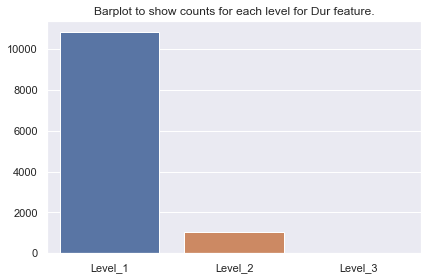

In [202]:
ax=sns.barplot(data_infected_host["New_Dur"].value_counts().index,data_infected_host["New_Dur"].value_counts().values)
ax.set_title("Barplot to show counts for each level for Dur feature.")
plt.show()

Based on this discritization and the barplots of the different levels of the individual features we see that values majorly in the range of level_1 for both "Dur"(0.0-367.65 seconds) and "TotBytes"(66-1066 bytes).

To combine features, the cartesian product of the three levels for each of two feature gives 9 possibilites as shown below-: 


| Dur           | TotBytes      | Combined_Feature |
| ------------- |:-------------:| :---------------:|
| Level_1       |  Level_1      | Combined_Level_1 |
| Level_1       |  Level_2      | Combined_Level_2 |
| Level_1       |  Level_3      | Combined_Level_3 |
| Level_2       |  Level_1      | Combined_Level_4 | 
| Level_2       |  Level_2      | Combined_Level_5 |   
| Level_2       |  Level_3      | Combined_Level_6 | 
| Level_3       |  Level_1      | Combined_Level_7 |
| Level_3       |  Level_2      | Combined_Level_8 |
| Level_3       |  Level_3      | Combined_Level_9 | 


In [212]:
combined_levels=[]
for i,j in zip(data_infected_host["New_Dur"].values,data_infected_host["New_TotBytes"].values):
    if (i=="Level_1") & (j=="Level_1"):
        combined_levels.append("Combined_Level_1")
    elif (i=="Level_1") & (j=="Level_2"):
        combined_levels.append("Combined_Level_2")
    elif (i=="Level_1") & (j=="Level_3"):
        combined_levels.append("Combined_Level_3")
    elif (i=="Level_2") & (j=="Level_1"):
        combined_levels.append("Combined_Level_4")
    elif (i=="Level_2") & (j=="Level_2"):
        combined_levels.append("Combined_Level_5")
    elif (i=="Level_2") & (j=="Level_3"):
        combined_levels.append("Combined_Level_6")
    elif (i=="Level_3") & (j=="Level_1"):
        combined_levels.append("Combined_Level_7")
    elif (i=="Level_3") & (j=="Level_2"):
        combined_levels.append("Combined_Level_8")
    elif (i=="Level_3") & (j=="Level_3"):
        combined_levels.append("Combined_Level_9")
        

In [213]:
data_infected_host.loc[:,"Combined_Levels"]=combined_levels

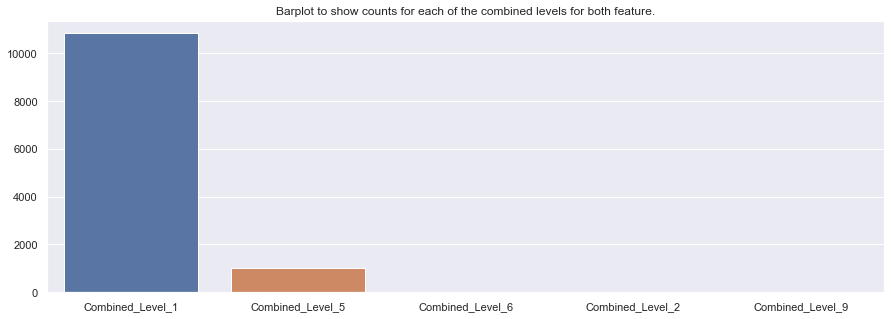

In [214]:
fig,ax= plt.subplots(figsize=(15,5))
ax=sns.barplot(data_infected_host["Combined_Levels"].value_counts().index,data_infected_host["Combined_Levels"].value_counts().values)
ax.set_title("Barplot to show counts for each of the combined levels for both feature.")
plt.show()


Overall, we see that combined_level_1 for this host is quite indicative of malicious activity. This is essentially when Dur and TotBytes level_1s are combined, this is expected ofcourse as they were the most indicative levels for the individual features as well. We then see that combined_level 5 which is a combination of Level_2 from the both features has the second highest frequency.  

In [219]:
#As a final aspect of the first task, we are asked to discretize our chosen features for every host. 
#Therefore I will do the discretization for the entire dataset without background.
data_discrete= data_WB_cleaned.copy()
#Lets discretize the feature TotBytes now.
data_discrete.loc[(data_discrete['TotBytes']>59.99) &(data_discrete['TotBytes']<=1066.0) ,'New_TotBytes'] = 'Level_1'
data_discrete.loc[(data_discrete['TotBytes']>1066) &(data_discrete['TotBytes']<=55432) ,'New_TotBytes'] = 'Level_2'
data_discrete.loc[(data_discrete['TotBytes']>55432),'New_TotBytes'] = 'Level_3'
#Lets discretize the feature Dur now.
Binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
data_discrete.loc[:,"New_Dur"]=Binner.fit_transform(data_discrete["Dur"].values.reshape(-1,1))
data_discrete.loc[(data_discrete['New_Dur']==0.0) ,'New_Dur'] = 'Level_1'
data_discrete.loc[(data_discrete['New_Dur']==1.0) ,'New_Dur'] = 'Level_2'
data_discrete.loc[(data_discrete['New_Dur']==2.0) ,'New_Dur'] = 'Level_3'

In [220]:
combined_levels_d=[]
for i,j in zip(data_discrete["New_Dur"].values,data_discrete["New_TotBytes"].values):
    if (i=="Level_1") & (j=="Level_1"):
        combined_levels_d.append("Combined_Level_1")
    elif (i=="Level_1") & (j=="Level_2"):
        combined_levels_d.append("Combined_Level_2")
    elif (i=="Level_1") & (j=="Level_3"):
        combined_levels_d.append("Combined_Level_3")
    elif (i=="Level_2") & (j=="Level_1"):
        combined_levels_d.append("Combined_Level_4")
    elif (i=="Level_2") & (j=="Level_2"):
        combined_levels_d.append("Combined_Level_5")
    elif (i=="Level_2") & (j=="Level_3"):
        combined_levels_d.append("Combined_Level_6")
    elif (i=="Level_3") & (j=="Level_1"):
        combined_levels_d.append("Combined_Level_7")
    elif (i=="Level_3") & (j=="Level_2"):
        combined_levels_d.append("Combined_Level_8")
    elif (i=="Level_3") & (j=="Level_3"):
        combined_levels_d.append("Combined_Level_9")

In [221]:
data_discrete["Combined_levels"] = combined_levels_d

In [222]:
data_discrete["Combined_levels"].value_counts()

Combined_Level_1    109068
Combined_Level_5      9326
Combined_Level_2      3245
Combined_Level_3       275
Combined_Level_6       144
Combined_Level_8        88
Combined_Level_9        29
Combined_Level_7        18
Combined_Level_4         6
Name: Combined_levels, dtype: int64

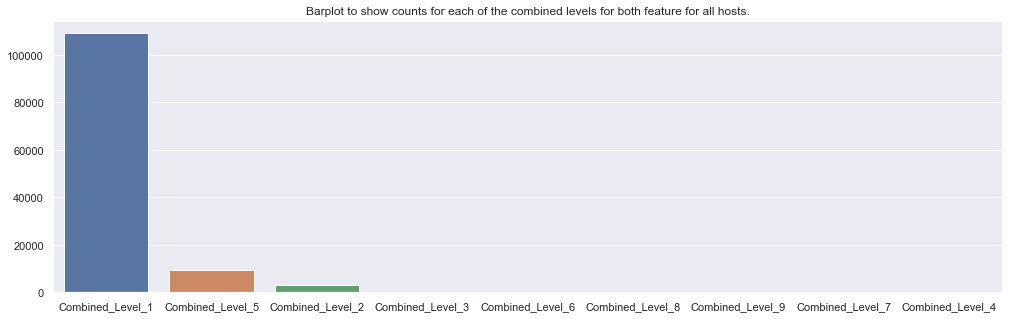

In [223]:
fig,ax= plt.subplots(figsize=(17,5))
ax=sns.barplot(data_discrete["Combined_levels"].value_counts().index,data_discrete["Combined_levels"].value_counts().values)
ax.set_title("Barplot to show counts for each of the combined levels for both feature for all hosts.")
plt.show()
# This is the end of the first task. 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


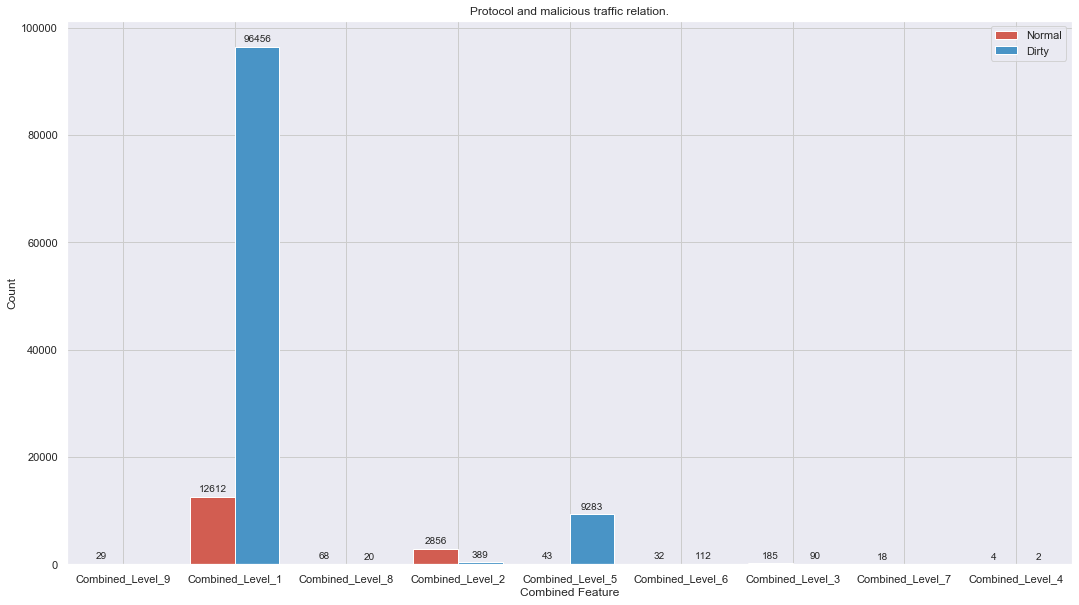

In [225]:
sns.set(rc={'figure.figsize':(18,10)})
    
flatui = ["#e74c3c","#3498db", "#2ecc71"]
ax = sns.countplot(x="Combined_levels", hue="Label", data=data_discrete, palette=flatui)
ax.set_title('Protocol and malicious traffic relation.')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel('Combined Feature')
ax.legend(["Normal", "Dirty"])
max_height = 0

for p in ax.patches:
    if p.get_height() > max_height:
        max_height = p.get_height()
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 0.01*max_height,'{:1d}'.format(height.astype(int)),
            ha="center",size=10)

This figure gives us a count for each of the levels of the combined_features for malicious and normal netflows. We see combined_level_1 and 8 are majorily representing malicious netflows.

### Spave Saving- Aditya Kunar


In [226]:
#Without space saving to compare results with space saving.
from nltk import ngrams

#These are the values of my combined_feature.
Combined_feature=data_discrete.Combined_levels.values

#Creating the different n-grams.
n = 3
threegrams = ngrams(Combined_feature, n)

#Creating a dictionary that stores the counts for the different ngrams. 
dicky={}
for i in threegrams:
    s = "-"
    s = s.join(i)
    dicky[s] = dicky.get(s, 0) + 1

#Sorting the dictionary.
dicky_sorted={k: v for k, v in sorted(dicky.items(), key=lambda item: -1*item[1])} 
#Returning top 10 as demanded in the task.
top10 = {k: dicky_sorted[k] for k in list(dicky_sorted)[:10]}
top10

{'Combined_Level_1-Combined_Level_1-Combined_Level_1': 88942,
 'Combined_Level_1-Combined_Level_5-Combined_Level_1': 7687,
 'Combined_Level_1-Combined_Level_1-Combined_Level_5': 7656,
 'Combined_Level_5-Combined_Level_1-Combined_Level_1': 7643,
 'Combined_Level_1-Combined_Level_1-Combined_Level_2': 1633,
 'Combined_Level_2-Combined_Level_1-Combined_Level_1': 1632,
 'Combined_Level_1-Combined_Level_2-Combined_Level_1': 1390,
 'Combined_Level_2-Combined_Level_2-Combined_Level_2': 1023,
 'Combined_Level_5-Combined_Level_1-Combined_Level_5': 772,
 'Combined_Level_1-Combined_Level_5-Combined_Level_5': 742}

In [228]:
#With space saving. 
from nltk import ngrams

Combined_feature=data_discrete.Combined_levels.values


"""
SpaceSpaver-> Here I implement the space saving algorithm as described in the lecture slides. 
              Inputs-:
              feature=> the feature I discretized in task1,
              gram_length=> 3 in our case as we want 3-grams.
              k=> The number of counters we want to use. 
"""
def SpaceSpaver(feature,gram_length,k):
    threegrams = ngrams(feature, gram_length)
    dicky_SV={}
    for i in threegrams:
        s = "-"
        s = s.join(i)
        if len(list(dicky_SV.keys()))<=k:
            dicky_SV[s] = dicky_SV.get(s, 0) + 1
        elif len(list(dicky_SV.keys()))>k:
            if s in list(dicky_SV.keys()):
                dicky_SV[s]+=1
            else:
                keytoR=(min(dicky_SV, key=dicky_SV.get))
                dicky_SV[s] = dicky_SV.pop(keytoR)
                dicky_SV[s]+=1

    dicky_SV_sorted={k: v for k, v in sorted(dicky_SV.items(), key=lambda item: -1*item[1])} 
    top10_SV = {k: dicky_SV_sorted[k] for k in list(dicky_SV_sorted)[:10]}
    return top10_SV

In [231]:
#Using the space-saver with 12 counters. 
top10_SV=SpaceSpaver(Combined_feature,3,12)
top10_SV

{'Combined_Level_1-Combined_Level_1-Combined_Level_1': 88942,
 'Combined_Level_1-Combined_Level_5-Combined_Level_1': 7764,
 'Combined_Level_1-Combined_Level_1-Combined_Level_5': 7730,
 'Combined_Level_5-Combined_Level_1-Combined_Level_1': 7714,
 'Combined_Level_1-Combined_Level_1-Combined_Level_2': 1634,
 'Combined_Level_2-Combined_Level_1-Combined_Level_1': 1634,
 'Combined_Level_1-Combined_Level_2-Combined_Level_1': 1392,
 'Combined_Level_2-Combined_Level_2-Combined_Level_2': 1026,
 'Combined_Level_5-Combined_Level_1-Combined_Level_5': 929,
 'Combined_Level_1-Combined_Level_5-Combined_Level_5': 902}

In [232]:
#These are the elements not present in the top 10 Space Spaving item list but are present in the actual top 10.  
set(top10.keys())-set(top10_SV.keys())


set()

We see that all 10 elements are correctly identified if we just use 12 counters. 

In [242]:
error=[]
for k in range(1,12):
    top10_SV=SpaceSpaver(Combined_feature,3,k)
    error.append(len(list(set(top10.keys())-set(top10_SV.keys()))))

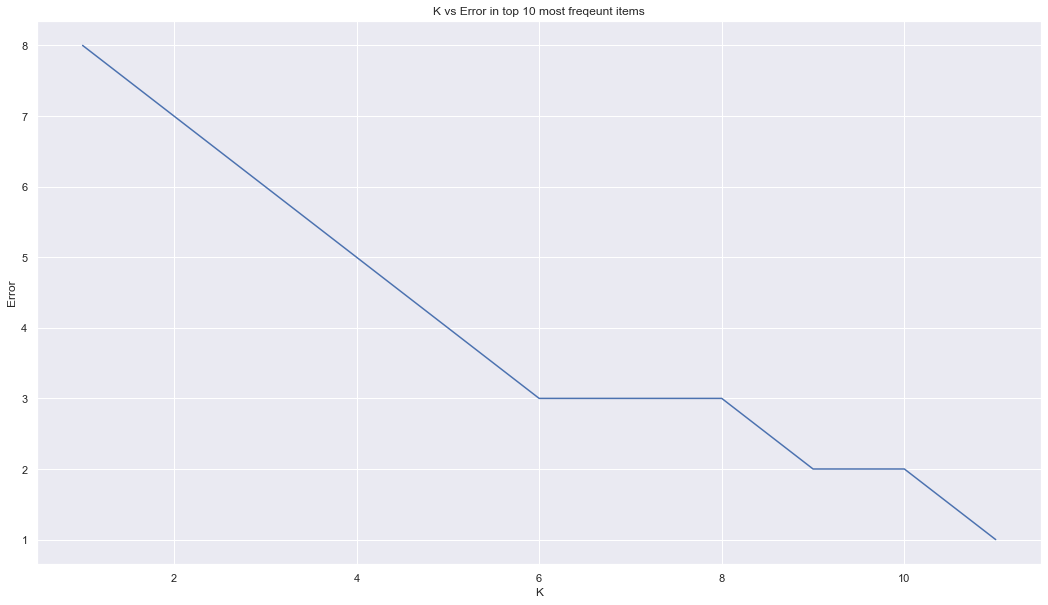

In [243]:
ax=sns.lineplot(x=range(1,12),y=error)
ax.set_title("K vs Error in top 10 most freqeunt items")
ax.set_xlabel("K")
ax.set_ylabel("Error")
plt.show()

We see that if we use a moderate number of counters, the top 10 correct elements are more easily identified. 

In [244]:
abserror=[]
for k in range(30):
    top10_SV=SpaceSpaver(Combined_feature,3,k)
    aberr=[]
    for i,j in zip(top10_SV.values(),top10.values()):
            aberr.append(abs(j-i))
    
    abserror.append(sum(aberr))

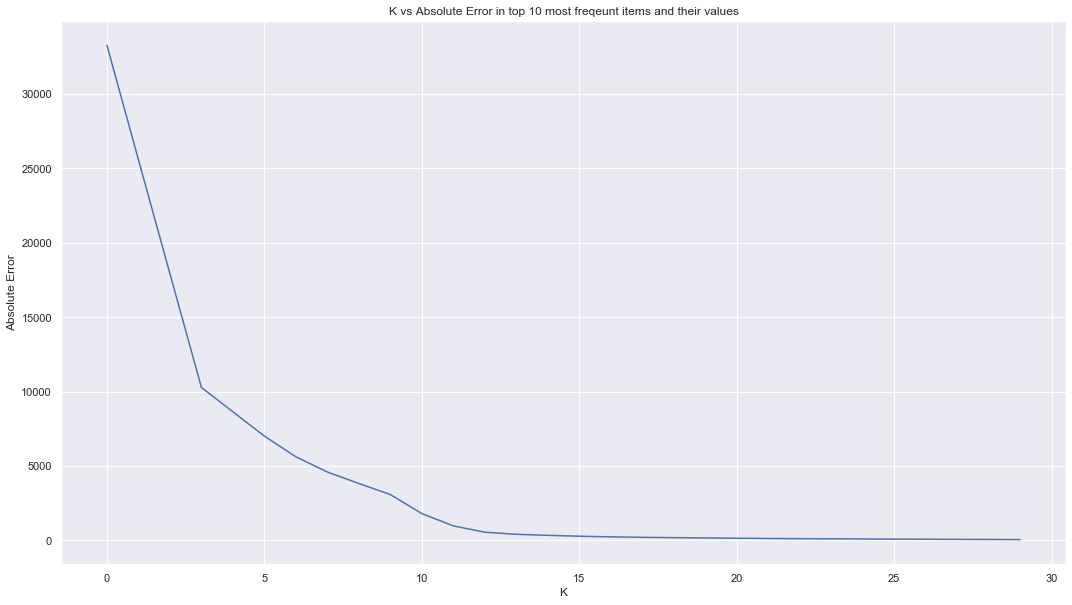

In [245]:
ax=sns.lineplot(x=range(30),y=abserror)
ax.set_title("K vs Absolute Error in top 10 most freqeunt items and their values")
ax.set_xlabel("K")
ax.set_ylabel("Absolute Error")
plt.show()

Using more counters increases the overall accuracy of the counts of the elements as well as shown in the graph.

We see that the dataset is clearly skewed based on the barplots shown before. The basic intuition of the space saving algorithm is to make use of the skewed property of the data, since we expect a minority of the elements that are the more frequent ones to get the majority of the hits. Frequent elements will reside in the counters of bigger values, and will not be distorted by the ineffective hits of the infrequent elements, and thus, will never be replaced out of
the monitored counters. Meanwhile, the numerous infrequent elements will be
striving to reside on the smaller counters, whose values will grow slower than
those of the larger counters. The elements that
are growing more popular will gradually be pushed to the top of the list as they
receive more hits. If one of the previously popular elements lost its popularity,
it will receive less hits. Thus, its relative position will decline, as other counters
get incremented, and it might eventually get dropped from the list.
Even if the data is not skewed, the errors in the counters will be inversely
proportional to the number of counters, this is also shown by my graphs as well. Keeping only a moderate
number of counters will guarantee very small errors. This is because the more
counters we keep, the less it is probable to replace elements, and thus, the smaller
the over-estimation errors in counters’ values.

### Minwise LSH -Aditya Kunar

For this task-:

1) I first obtain the ip pairs. 

2) I then extract the combined_feature that was used in task1 from the ip-pair subsets and create n-grams. 

3) I filter the ip-pairs which do not have any 3-grams as they do not need to be hashed.

4) I create the min-hash table.

5) I perform the algorithm of minwise LSH hashing to get the signature matrix.

6) I finally compare the errors of the jaccard similarity with the signiture similarity based on the number of hash functions and the number of bins used. 

In [70]:
#getting the unique IP pairs.
src=data_discrete["SrcAddr"].values
dst=data_discrete["DstAddr"].values
ip_pairs=[]
for i,j in zip(src,dst):
    ip_pairs.append((i,j))
unique_pairs=list(set(ip_pairs))    

In [71]:
#Getting the combined_features for each IP-pair and creating n-grams. 
datasubsets=[]
for i in set(unique_pairs):
    datasubsets.append(data_discrete.loc[(data_discrete["SrcAddr"]==i[0])&(data_discrete["DstAddr"]==i[1])])

Combined_pairF=[]
for i in datasubsets:
    Combined_pairF.append(i["Combined_levels"].values)    
    
Ngram_combined_pairF=[]

for i in Combined_pairF:
    threegrams = ngrams(i, 3)
    Ngram_combined_pairF.append(threegrams)     
    
# Big dicky stores the different n-grams and their counts for each ip-pair.     
BigDicky=[]
for i in Ngram_combined_pairF:
    dicky={}
    for j in i:
        s = "-"
        s = s.join(j)
        dicky[s] = dicky.get(s, 0) + 1
    
    BigDicky.append(dicky)    

In [72]:
BigDicky  

[{},
 {},
 {},
 {'Combined_Level_5-Combined_Level_5-Combined_Level_5': 5},
 {},
 {'Combined_Level_5-Combined_Level_5-Combined_Level_5': 5,
  'Combined_Level_5-Combined_Level_5-Combined_Level_6': 1,
  'Combined_Level_5-Combined_Level_6-Combined_Level_5': 1},
 {'Combined_Level_5-Combined_Level_5-Combined_Level_5': 1},
 {},
 {},
 {'Combined_Level_1-Combined_Level_1-Combined_Level_1': 5},
 {},
 {},
 {},
 {},
 {'Combined_Level_1-Combined_Level_1-Combined_Level_1': 2},
 {'Combined_Level_5-Combined_Level_5-Combined_Level_5': 17,
  'Combined_Level_5-Combined_Level_5-Combined_Level_1': 1,
  'Combined_Level_5-Combined_Level_1-Combined_Level_1': 1,
  'Combined_Level_1-Combined_Level_1-Combined_Level_1': 2,
  'Combined_Level_1-Combined_Level_1-Combined_Level_5': 1,
  'Combined_Level_1-Combined_Level_5-Combined_Level_5': 1},
 {'Combined_Level_2-Combined_Level_2-Combined_Level_2': 1},
 {'Combined_Level_5-Combined_Level_5-Combined_Level_5': 6,
  'Combined_Level_5-Combined_Level_5-Combined_Level_4': 1

In [73]:
#Removing the empty ip_pairs.
index=[]
for i in enumerate(BigDicky):
    if len(list(i[1].keys()))!=0:
        index.append(i[0]) 
BigDicky_pure = [i[1] for i in enumerate(list(BigDicky)) if i[0] in index]        
BigDicky=BigDicky_pure

In [74]:
BigDicky

[{'Combined_Level_5-Combined_Level_5-Combined_Level_5': 5},
 {'Combined_Level_5-Combined_Level_5-Combined_Level_5': 5,
  'Combined_Level_5-Combined_Level_5-Combined_Level_6': 1,
  'Combined_Level_5-Combined_Level_6-Combined_Level_5': 1},
 {'Combined_Level_5-Combined_Level_5-Combined_Level_5': 1},
 {'Combined_Level_1-Combined_Level_1-Combined_Level_1': 5},
 {'Combined_Level_1-Combined_Level_1-Combined_Level_1': 2},
 {'Combined_Level_5-Combined_Level_5-Combined_Level_5': 17,
  'Combined_Level_5-Combined_Level_5-Combined_Level_1': 1,
  'Combined_Level_5-Combined_Level_1-Combined_Level_1': 1,
  'Combined_Level_1-Combined_Level_1-Combined_Level_1': 2,
  'Combined_Level_1-Combined_Level_1-Combined_Level_5': 1,
  'Combined_Level_1-Combined_Level_5-Combined_Level_5': 1},
 {'Combined_Level_2-Combined_Level_2-Combined_Level_2': 1},
 {'Combined_Level_5-Combined_Level_5-Combined_Level_5': 6,
  'Combined_Level_5-Combined_Level_5-Combined_Level_4': 1,
  'Combined_Level_5-Combined_Level_4-Combined_Le

In [75]:
#Total number of the different n-gram types. 
allkeys=[]
for i in BigDicky:
    for j in list(i.keys()):
        allkeys.append(j)
len(set(allkeys))        

177

In [76]:
#creating the minhash table as described in the lecture.
# Here the rows are the ip-pair profiles and the columns are the different n-gram types.
# 1 indicates that the ngram was present and 0 otherwise. 
df=pd.DataFrame(np.zeros((299,177)),columns=list(set(allkeys)))

for k in enumerate(BigDicky):
    for i in df.columns:
        if i in list(k[1].keys()):
            df.loc[k[0],i]=1

In [77]:
#Transposing this dataframe to get the proper minhash table where columns are the profiles and rows are different n-grams. 
minhashtable=df.values.T

In [78]:
#This calculates the jaccard_similarity. 
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [79]:
#Prepocessing step to get the indexes of the ones to compute jaccard similarity. 
indexes=[]
for i in range(minhashtable.shape[1]):
    index=[x[0] for x in enumerate(minhashtable[:,i]) if x[1]==1]
    indexes.append(index)

In [80]:
#Timing the operation of calculating all pair-wise jaccard similarities. 
t1=time.perf_counter()
pair_wise_sim=[]
for i in indexes:
    for j in indexes:
        pair_wise_sim.append(jaccard_similarity(i,j))
pair_wise_sim=np.array(pair_wise_sim).reshape(len(BigDicky),len(BigDicky))
t2=time.perf_counter()
print("Time to execute this was "+str(t2-t1)+" seconds.")

Time to execute this was 0.11798870000001216 seconds.


In [81]:
#Seeing the pair_wise_similarity for each ip_pair. 
pd.DataFrame(pair_wise_sim)

,0,1,2,3,4,5,6,7,8,9,...,289,290,291,292,293,294,295,296,297,298
0,1.000000,0.333333,1.000000,0.000000,0.000000,0.166667,0.0,0.125000,0.000000,0.0,...,0.0,0.50,0.000000,0.166667,1.000000,0.25,0.000000,0.000000,0.0,0.000000
1,0.333333,1.000000,0.333333,0.000000,0.000000,0.125000,0.0,0.222222,0.000000,0.0,...,0.0,0.25,0.000000,0.285714,0.333333,0.75,0.000000,0.000000,0.0,0.000000
2,1.000000,0.333333,1.000000,0.000000,0.000000,0.166667,0.0,0.125000,0.000000,0.0,...,0.0,0.50,0.000000,0.166667,1.000000,0.25,0.000000,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,1.000000,1.000000,0.166667,0.0,0.000000,1.000000,0.0,...,0.0,0.00,0.083333,0.000000,0.000000,0.00,0.333333,1.000000,0.0,1.000000
4,0.000000,0.000000,0.000000,1.000000,1.000000,0.166667,0.0,0.000000,1.000000,0.0,...,0.0,0.00,0.083333,0.000000,0.000000,0.00,0.333333,1.000000,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.250000,0.750000,0.250000,0.000000,0.000000,0.111111,0.0,0.200000,0.000000,0.0,...,0.0,0.20,0.000000,0.428571,0.250000,1.00,0.000000,0.000000,0.0,0.000000
295,0.000000,0.000000,0.000000,0.333333,0.333333,0.125000,0.0,0.000000,0.333333,0.0,...,0.0,0.00,0.071429,0.000000,0.000000,0.00,1.000000,0.333333,0.0,0.333333
296,0.000000,0.000000,0.000000,1.000000,1.000000,0.166667,0.0,0.000000,1.000000,0.0,...,0.0,0.00,0.083333,0.000000,0.000000,0.00,0.333333,1.000000,0.0,1.000000
297,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5,0.000000,0.000000,0.0,...,0.0,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,1.0,0.000000


In [83]:
# Defining the number of hash functions and number of bins to be used.

"""
hash_func_gen=> It is used to generate the hash functions. 
                Inputs:-
                N-> Controls the number of hash functions to be generated.
                b-> Controls the number of bins we want. b has to be greater than 1. 
                    b doesn't directly correspond to number of bins, for ex 
                    if b=2 it's not going to be 2 bins. But basically if you want more bins
                    you provide a higher b value. 
"""
def hash_func_gen(N,bc):
    N_HASHES = N

    #Creating the different hash functions. 
    def universal_hashing():
        def rand_prime():
            while True:
                p = random.randrange(2 **1 , 2 ** bc, 2)
                if all(p % n != 0 for n in range(3, int((p ** 0.5) + 1), 2)):
                    return p
        m = 2 ** 32 - 1
        p = rand_prime()
        a = random.randint(0, p)
        if a % 2 == 0:
            a += 1
        b = random.randint(0, p)
        def h(x):
            return ((a * x + b) % p) % m
        return h

    hash_funcs = []
    for i in range(N_HASHES):
        hash_funcs.append(universal_hashing())
    return hash_funcs    

In [91]:
#Generating the hash_funcs
No_hash_funcs=50
hash_funcs=hash_func_gen(No_hash_funcs,3)
max([h(1) for h in hash_funcs])+1 #Number of bins being used to hash row values. 

6

In [92]:
#Defining M the signature matrix. 
M= np.full((50, 299), np.inf)
M

array([[inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

In [86]:
# This is where i perform the min-wis LSH to get the signature matrix. 
for i in range(minhashtable.shape[0]):
    hash_vals=[h(i) for h in hash_funcs]
    for j in range(minhashtable.shape[1]):
        c= minhashtable[:,j]
        if c[i]==1:
            for v in enumerate(hash_vals):
                if v[1] < M[v[0],j]:
                    M[v[0],j]=v[1]
        else:
            continue
        

In [89]:
#What M looks like.
M

array([[4., 1., 4., ..., 0., 1., 0.],
       [4., 1., 4., ..., 0., 1., 0.],
       [4., 1., 4., ..., 4., 1., 4.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [2., 2., 2., ..., 4., 3., 4.]])

In [87]:
#Here i compute the signature similarity. 
t1=time.perf_counter()
pair_wise_M_sim=[]
for i in range(M.shape[1]):
    for j in range(M.shape[1]):
            pair_wise_M_sim.append(((M[:,i]==M[:,j]).sum())/50)
t2=time.perf_counter()
print("Time to execute this was "+str(t2-t1)+" seconds.")            

Time to execute this was 0.39288120000003346 seconds.


In [96]:
#Pair_wise Signature similarity between ip_pair profiles. 
pd.DataFrame(np.array(pair_wise_M_sim).reshape(len(BigDicky),len(BigDicky)))

,0,1,2,3,4,5,6,7,8,9,...,289,290,291,292,293,294,295,296,297,298
0,1.00,0.36,1.00,0.08,0.08,0.26,0.00,0.24,0.08,0.00,...,0.04,0.54,0.14,0.26,1.00,0.30,0.04,0.08,0.00,0.08
1,0.36,1.00,0.36,0.06,0.06,0.42,0.04,0.44,0.06,0.12,...,0.04,0.30,0.32,0.46,0.36,0.82,0.04,0.06,0.08,0.06
2,1.00,0.36,1.00,0.08,0.08,0.26,0.00,0.24,0.08,0.00,...,0.04,0.54,0.14,0.26,1.00,0.30,0.04,0.08,0.00,0.08
3,0.08,0.06,0.08,1.00,1.00,0.28,0.00,0.10,1.00,0.00,...,0.26,0.20,0.10,0.06,0.08,0.06,0.36,1.00,0.00,1.00
4,0.08,0.06,0.08,1.00,1.00,0.28,0.00,0.10,1.00,0.00,...,0.26,0.20,0.10,0.06,0.08,0.06,0.36,1.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.30,0.82,0.30,0.06,0.06,0.40,0.06,0.46,0.06,0.10,...,0.04,0.26,0.38,0.56,0.30,1.00,0.08,0.06,0.12,0.06
295,0.04,0.04,0.04,0.36,0.36,0.22,0.10,0.16,0.36,0.00,...,0.18,0.20,0.18,0.14,0.04,0.08,1.00,0.36,0.10,0.36
296,0.08,0.06,0.08,1.00,1.00,0.28,0.00,0.10,1.00,0.00,...,0.26,0.20,0.10,0.06,0.08,0.06,0.36,1.00,0.00,1.00
297,0.00,0.08,0.00,0.00,0.00,0.02,0.62,0.06,0.00,0.10,...,0.00,0.00,0.16,0.22,0.00,0.12,0.10,0.00,1.00,0.00


In [88]:
#Error between jaccard and signature similarity for 6 bins for hashing row values and 50 hash functions. 
errors=(pair_wise_sim-np.array(pair_wise_M_sim).reshape(len(BigDicky),len(BigDicky)))**2
err=(errors.ravel().sum())/len(errors.ravel())

0.19579298478304613

In [95]:
#Affect of increasing number of bins. 
e=[]
b=[2,3,4,5,6]
for i in b:
    No_hash_funcs=50
    hash_funcs=hash_func_gen(No_hash_funcs,i)
    print("Number of bins being used "+str(max([h(1) for h in hash_funcs])+1))
    M= np.full((50, 299), np.inf)
    for i in range(minhashtable.shape[0]):
        hash_vals=[h(i) for h in hash_funcs]
        for j in range(minhashtable.shape[1]):
            c= minhashtable[:,j]
            if c[i]==1:
                for v in enumerate(hash_vals):
                    if v[1] < M[v[0],j]:
                        M[v[0],j]=v[1]
            else:
                continue
    pair_wise_M_sim=[]
    for i in range(M.shape[1]):
        for j in range(M.shape[1]):
                pair_wise_M_sim.append(((M[:,i]==M[:,j]).sum())/50)
    errors=(pair_wise_sim-np.array(pair_wise_M_sim).reshape(len(BigDicky),len(BigDicky)))**2
    err=(errors.ravel().sum())/len(errors.ravel())
    print(err)
    

Number of bins being used 2
0.406415190203388
Number of bins being used 6
0.16541282438884253
Number of bins being used 14
0.07565338595150418
Number of bins being used 26
0.04256309249069298
Number of bins being used 52
0.01897131420531574


First we see that if jaccard similarity is zero for two ip-pair profiles, it is also zero for the signature similarity between them. The cool thing about using minhash table is that jaccard similarity is approximated as signature similarity as this is a property of the algorithm. The reason why this is faster is perhaps because we have lesser rows represented by the number of hash functions used in the signature matrix which is much lesser than the total number of different N-grams for the original minhash table for computing jaccard similarity. In my case it wasn't faster but this is because I had only 177 different N-grams. This number is much bigger for common datasets and so the speed up is more advantageous if one has more different n-gram types. Moreover we see that error goes down with the more number of bins used to hash the row values as well. So in conclusion we see if we use more bins to hash row values, the approximate error in the values goes down and the speed up can be increased if we use lesser hash functions overall. 
